# STA 141B: Homework 5
Winter 2018

## Student Information

After the colons (in the same line) please write just your first name, last name, and the 9 digit student ID number below.

First Name:Qixian 

Last Name: Zhao

Student ID: 915625172

## Instructions

We use a script that extracts your answers by looking for cells in between the cells containing the exercise statements.  So you 

- MUST add cells in between the exercise statements and add answers within them and
- MUST NOT modify the existing cells, particularly not the problem statement

To make markdown, please switch the cell type to markdown (from code) - you can hit 'm' when you are in command mode - and use the markdown language.  For a brief tutorial see: https://daringfireball.net/projects/markdown/syntax

# Housing data

In this assignment, you'll analyze a collection of data sets from the [San Francisco Open Data Portal](http://data.sfgov.org/) and [Zillow](https://www.zillow.com/). The data sets have been stored in the SQLite database `sf_data.sqlite`, which you can [download here](http://anson.ucdavis.edu/~nulle/sf_data.sqlite). The database contains the following tables:

Table                   | Description
----------------------- | -----------
`crime`                 | Crime reports dating back to 2010.
`mobile_food_locations` | List of all locations where mobile food vendors sell.
`mobile_food_permits`   | List of all mobile food vendor permits. More details [here](https://data.sfgov.org/api/views/rqzj-sfat/files/8g2f5RV4PEk0_b24iJEtgEet9gnh_eA27GlqoOjjK4k?download=true&filename=DPW_DataDictionary_Mobile-Food-Facility-Permit.pdf).
`mobile_food_schedule`  | Schedules for mobile food vendors.
`noise`                 | Noise complaints dating back to August 2015.
`parking`               | List of all parking lots.
`parks`                 | List of all parks.
`schools`               | List of all schools.
`zillow`                | Zillow rent and housing statistics dating back to 1996. More details [here](https://www.zillow.com/research/data/).

The `mobile_food_` tables are explicitly connected through the `locationid` and `permit` columns. The other tables are not connected, but you may be able to connect them using dates, latitude/longitude, or postal codes.

Shapefiles for US postal codes are available [here](https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html). These may be useful for converting latitude/longitude to postal codes.

Shapefiles for San Francisco Neighborhoods are available [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4).

In [35]:
import pandas as pd
import numpy as np  
import zipcode
import re
from matplotlib import pyplot as plt
import seaborn as sns
import sqlalchemy as sqla
import shapefile as shp
import sqlite3 as sql
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd         
import osmnx as ox           
import shapely
import shapely.geometry as geom
plt.style.use('ggplot')
from urllib import request

__Data Preparation__

In [36]:
sf_data=sql.connect("sf_data.sqlite")

In [38]:
#download San Francisco Neighborhoods from the url
import zipfile, urllib.request, shutil
url = "https://data.sfgov.org/api/geospatial/pty2-tcw4?method=export&format=Shapefile"
file_name = "SF Find Neighborhoods.zip"

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(file_name) as zf:
        zf.extractall()

In [11]:
sf_neighborhoods=gpd.read_file("geo_export_94acb812-c280-4e39-b6ca-a186665f9748.shp")
sf_neighborhoods.head()

,link,name,geometry
0,"http://en.wikipedia.org/wiki/Sea_Cliff,_San_Fr...",Seacliff,POLYGON ((-122.4934552679999 37.78351817100008...
1,None,Lake Street,POLYGON ((-122.4871507149999 37.78378542700005...
2,http://www.nps.gov/prsf/index.htm,Presidio National Park,POLYGON ((-122.4775801709999 37.81099311300005...
3,None,Presidio Terrace,POLYGON ((-122.4724105299999 37.78734653900005...
4,http://www.sfgate.com/neighborhoods/sf/innerri...,Inner Richmond,POLYGON ((-122.4726257899999 37.78631480600006...


In [12]:
pd.read_sql("SELECT*FROM sqlite_master",sf_data)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."
9,table,crime2,crime2,36105,"CREATE TABLE ""crime2"" (\n""level_0"" INTEGER,\n ..."


In [13]:
#generate a 'neighbourhood' column for the crime table.
crime_lon_lat=pd.read_sql("SELECT Lon,Lat FROM crime",sf_data)
crime_points=[geom.Point(x) for x in crime_lon_lat.values]

In [6]:
crime_points_df=gpd.GeoDataFrame(crime_lon_lat,geometry=crime_points)

In [7]:
neighborhoods=gpd.sjoin(crime_points_df,sf_neighborhoods,how='inner',op='within').name

In [8]:
print(crime_points_df.crs)
print(sf_neighborhoods.crs)

None
{'init': 'epsg:4326'}


In [14]:
neigh_df=pd.DataFrame(neighborhoods)
neigh_df.reset_index(level=0, inplace=True)
neigh_df.head()

,index,name
0,0,Mission Dolores
1,89,Mission Dolores
2,90,Mission Dolores
3,91,Mission Dolores
4,92,Mission Dolores


In [15]:
crime=pd.read_sql("SELECT * FROM crime",sf_data)
crime=crime.reset_index()
crime.head()

,index,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


In [16]:
crime2=crime.merge(neigh_df, on=['index'])

In [17]:
crime2.to_sql("crime2",sf_data,if_exists='replace')

In [18]:
crime2.head()

,index,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat,name
0,0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701,Mission Dolores
1,1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,Tenderloin
2,2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,Tenderloin
3,3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191,Tenderloin
4,4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469,Marina


In [39]:
#download San Francisco Neighborhoods US postal codes from the url
import zipfile, urllib.request, shutil
url = "http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_zcta510_500k.zip"
file_name = "cb_2016_us_zcta510_500k.zip"

with urllib.request.urlopen(url) as response, open(file_name, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)
    with zipfile.ZipFile(file_name) as zf:
        zf.extractall()

In [40]:
school_addresses=pd.read_sql("SELECT Address FROM schools",sf_data)
sf_unique_zipcodes=np.unique(np.array(["".join(re.findall("[0-9]+$",s)) for s in school_addresses.Address]))
us_zipcodes=gpd.read_file("cb_2016_us_zcta510_500k.shp")
us_zipcodes.AFFGEOID10=pd.Series([re.sub("8600000US","",z) for z in us_zipcodes.AFFGEOID10])
sf_zips=us_zipcodes.loc[np.in1d(us_zipcodes.AFFGEOID10.values,sf_unique_zipcodes)==True]
sf_zips=sf_zips.reset_index(drop=True)

__Basic Map__

Text(0.5,1,'San Francisco, by zipcode')

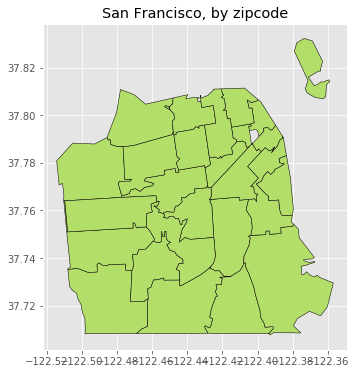

In [41]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sf_zips.plot(ax=plt.gca(),edgecolor = "black", color = "#b3de69")
plt.title("San Francisco, by zipcode")


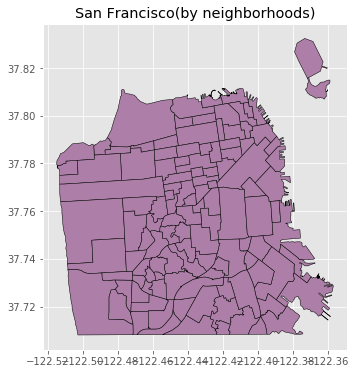

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,2)
sf_neighborhoods.plot(ax=plt.gca(),edgecolor = "black", color = "#ad7fa8")
plt.title("San Francisco(by neighborhoods)")
plt.show()

__Exercise 1.1.__ (20 pts) Which mobile food vendor(s) sells at the most locations?

Top 5:Park's Catering,D & T Catering,F & C Catering,Munch A Bunch,Eva's Catering	

In [43]:
pd.read_sql("SELECT*FROM sqlite_master",sf_data)

,type,name,tbl_name,rootpage,sql
0,table,crime,crime,2,"CREATE TABLE ""crime"" (\n""IncidntNum"" INTEGER,\..."
1,table,noise,noise,35775,"CREATE TABLE ""noise"" (\n""CaseID"" INTEGER,\n ""..."
2,table,parking,parking,35921,"CREATE TABLE ""parking"" (\n""Owner"" TEXT,\n ""Ad..."
3,table,schools,schools,35944,"CREATE TABLE ""schools"" (\n""Name"" TEXT,\n ""Ent..."
4,table,parks,parks,35961,"CREATE TABLE ""parks"" (\n""Name"" TEXT,\n ""Type""..."
5,table,zillow,zillow,35967,"CREATE TABLE ""zillow"" (\n""RegionName"" INTEGER,..."
6,table,mobile_food_permits,mobile_food_permits,36050,"CREATE TABLE ""mobile_food_permits"" (\n""permit""..."
7,table,mobile_food_locations,mobile_food_locations,36060,"CREATE TABLE ""mobile_food_locations"" (\n""locat..."
8,table,mobile_food_schedule,mobile_food_schedule,36079,"CREATE TABLE ""mobile_food_schedule"" (\n""locati..."
9,table,crime2,crime2,36105,"CREATE TABLE ""crime2"" (\n""level_0"" INTEGER,\n ..."


In [44]:
food_lic = pd.read_sql("SELECT * FROM mobile_food_locations",sf_data)
food_lic.head()

,locationid,LocationDescription,Address,Latitude,Longitude
0,762182,TOWNSEND ST: 05TH ST to 06TH ST (400 - 499),444 TOWNSEND ST,37.774871,-122.398532
1,437211,MISSOURI ST: 20TH ST to SIERRA ST (500 - 630),555 MISSOURI ST,37.759304,-122.395902
2,765880,17TH ST: SAN BRUNO AVE to UTAH ST (2200 - 2299),2222 17TH ST,37.765216,-122.406007
3,765690,CESAR CHAVEZ ST: EVANS AVE to KANSAS ST (2100 ...,2323 CESAR CHAVEZ ST,37.748801,-122.400552
4,751253,FOLSOM ST: 14TH ST to 15TH ST (1800 - 1899),1800 FOLSOM ST,37.767852,-122.416105


In [45]:
food_schedule=pd.read_sql("SELECT * FROM mobile_food_schedule",sf_data)
food_schedule.head()

,locationid,permit,DayOfWeek,EndHour,StartHour
0,305727,11MFF-0040,Mo,15,10
1,305727,11MFF-0040,Tu,15,10
2,305727,11MFF-0040,We,15,10
3,305727,11MFF-0040,Th,15,10
4,305727,11MFF-0040,Fr,15,10


In [46]:
food_permit=pd.read_sql("SELECT * FROM mobile_food_permits",sf_data)
food_permit.head()

,permit,Status,Applicant,FacilityType,FoodItems,PriorPermit,Approved,Expiration
0,16MFF-0027,APPROVED,F & C Catering,Truck,Cold Truck: Hot/Cold Sandwiches: Water: Soda: ...,1,2016-03-09 12:00:00,2017-03-15 12:00:00
1,13MFF-0102,EXPIRED,Natan's Catering,Truck,Burgers: melts: hot dogs: burritos:sandwiches:...,1,2013-04-12 12:00:00,2014-03-15 12:00:00
2,16MFF-0069,APPROVED,Munch A Bunch,Truck,Cold Truck: packaged sandwiches: pitas: breakf...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
3,16MFF-0051,APPROVED,Park's Catering,Truck,Cold Truck: Hamburger: cheeseburgers: hot dogs...,1,2016-03-15 12:00:00,2017-03-15 12:00:00
4,16MFF-0010,REQUESTED,Pipo's Grill,Truck,Tacos: Burritos: Hot Dogs: and Hamburgers,0,None,None


In [47]:
pd.read_sql("SELECT Applicant, count(Applicant) AS num_permits FROM mobile_food_permits AS mfp "
            "INNER JOIN (SELECT DISTINCT locationid, permit FROM mobile_food_schedule) "
            "AS mfs ON mfp.permit=mfs.permit WHERE mfp.Status=='APPROVED' GROUP BY mfp.Applicant "
            "ORDER BY num_permits DESC LIMIT 5",sf_data)

,Applicant,num_permits
0,Park's Catering,23
1,D & T Catering,17
2,F & C Catering,13
3,Munch A Bunch,10
4,Eva's Catering,8


__Exercise 1.2.__ (40 pts) Ask and use the database to analyze 5 questions about San Francisco. For each question, write at least 150 words and support your answer with plots. Make a map for at least 2 of the 5 questions.

You should try to come up with some questions on your own, but these are examples of reasonable questions:

* Which parts of the city are the most and least expensive?
* Which parts of the city are the most dangerous (and at what times)?
* Are noise complaints and mobile food vendors related?
* What are the best times and places to find food trucks?
* Is there a relationship between housing prices and any of the other tables?

Please make sure to clearly state each of your questions in your submission.

__1.Which parts of the city are the most dangerous (and at what times)?__

I use data about 'crime' from sf_data and select incident number, day of week and district. Then I count the number of distinct incident numbers by district and day of week. I make a bar plot for crime number with time and place and I find that the most dangerous time and part of the city is Friday in Southern district of San Francisco, with a number of crime incidents 30952. I also calculate incident number and day of week and calculate the number of distinct incident numbers by day of week. I make a bar plot for crime number with time and I find that the most dangerous time in San Francisco is Friday, with 159182 incidents. People will have higher risk to be involved in a crime incident on Friday and especially in Southern district of San Francisco and they should avoid going out at that time in that district.

In [48]:
pd.read_sql("SELECT count(IncidntNum) AS number_of_crime,PdDistrict, DayOfWeek FROM crime "
            "GROUP BY PdDistrict, DayOfWeek "
            "ORDER BY number_of_crime DESC LIMIT 5",sf_data)

,number_of_crime,PdDistrict,DayOfWeek
0,30952,SOUTHERN,Friday
1,29790,SOUTHERN,Saturday
2,28394,SOUTHERN,Wednesday
3,28150,SOUTHERN,Thursday
4,26614,SOUTHERN,Tuesday


In [49]:
crime=pd.read_sql("SELECT * FROM crime",sf_data)
crime.head()

,IncidntNum,Category,Descript,DayOfWeek,Datetime,PdDistrict,Resolution,Address,Lon,Lat
0,150060275,NON-CRIMINAL,LOST PROPERTY,Monday,2015-01-19 14:00:00,MISSION,NONE,18TH ST / VALENCIA ST,-122.421582,37.761701
1,150098210,ROBBERY,"ROBBERY, BODILY FORCE",Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
2,150098210,ASSAULT,AGGRAVATED ASSAULT WITH BODILY FORCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
3,150098210,SECONDARY CODES,DOMESTIC VIOLENCE,Sunday,2015-02-01 15:45:00,TENDERLOIN,NONE,300 Block of LEAVENWORTH ST,-122.414406,37.784191
4,150098226,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Tuesday,2015-01-27 19:00:00,NORTHERN,NONE,LOMBARD ST / LAGUNA ST,-122.431119,37.800469


In [50]:
crime_data=pd.read_sql("SELECT count(IncidntNum) AS number_of_crime,PdDistrict, DayOfWeek FROM crime "
                       "GROUP BY PdDistrict, DayOfWeek "
                       "ORDER BY number_of_crime DESC",sf_data)

In [51]:
#most dangerous
pd.read_sql("SELECT count(IncidntNum) AS number_of_crime,PdDistrict, DayOfWeek FROM crime "
            "GROUP BY PdDistrict, DayOfWeek "
            "ORDER BY number_of_crime DESC LIMIT 5",sf_data)

,number_of_crime,PdDistrict,DayOfWeek
0,30952,SOUTHERN,Friday
1,29790,SOUTHERN,Saturday
2,28394,SOUTHERN,Wednesday
3,28150,SOUTHERN,Thursday
4,26614,SOUTHERN,Tuesday


In [52]:
#least dangerous
pd.read_sql("SELECT count(IncidntNum) AS number_of_crime,PdDistrict, DayOfWeek FROM crime "
            "GROUP BY PdDistrict, DayOfWeek "
            "ORDER BY number_of_crime ASC LIMIT 6",sf_data)

,number_of_crime,PdDistrict,DayOfWeek
0,1,None,Sunday
1,7641,RICHMOND,Sunday
2,7746,RICHMOND,Monday
3,7827,RICHMOND,Tuesday
4,7991,RICHMOND,Thursday
5,8118,RICHMOND,Wednesday


In [53]:
crime_time=pd.read_sql("SELECT count(IncidntNum) AS number_of_crime, DayOfWeek FROM crime "
                       "GROUP BY DayOfWeek "
                       "ORDER BY number_of_crime DESC",sf_data)
crime_time

,number_of_crime,DayOfWeek
0,159182,Friday
1,151941,Saturday
2,150197,Wednesday
3,146130,Thursday
4,144353,Tuesday
5,141683,Monday
6,139915,Sunday


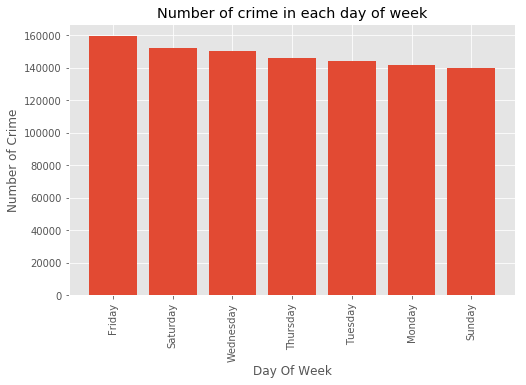

In [57]:
x = range(len(crime_time))
labels = crime_time['DayOfWeek']

plt.figure(figsize=(8, 5))
plt.xticks(x, labels, rotation = 'vertical')
plt.bar(x, crime_time['number_of_crime'])
plt.xlabel('Day Of Week')
plt.ylabel('Number of Crime')
plt.title('Number of crime in each day of week')
plt.show()

In [55]:
crime_place=pd.read_sql("SELECT count(IncidntNum) AS number_of_crime, PdDistrict FROM crime "
                        "GROUP BY PdDistrict "
                        "ORDER BY number_of_crime DESC",sf_data)
crime_place=pd.DataFrame(crime_place).dropna()
crime_place

,number_of_crime,PdDistrict
0,196178,SOUTHERN
1,136216,MISSION
2,124365,NORTHERN
3,109242,CENTRAL
4,101655,BAYVIEW
5,89044,INGLESIDE
6,84009,TENDERLOIN
7,75459,TARAVAL
8,60974,PARK
9,56258,RICHMOND


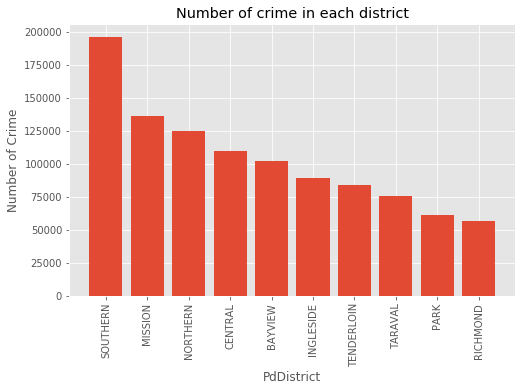

In [58]:
x = range(len(crime_place))
labels = crime_place['PdDistrict']
plt.figure(figsize=(8, 5))
plt.xticks(x, labels, rotation = 'vertical')
plt.bar(x, crime_place['number_of_crime'])
plt.xlabel('PdDistrict')
plt.ylabel('Number of Crime')
plt.title('Number of crime in each district')
plt.show()

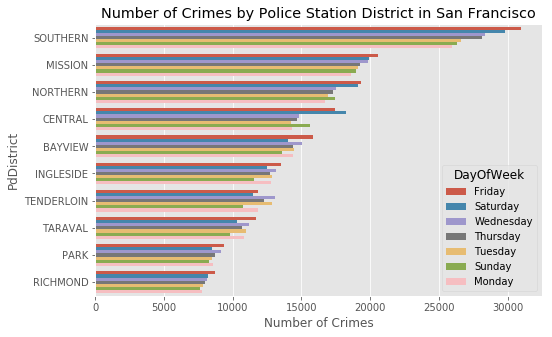

In [60]:
plt.figure(figsize=(8, 5))
plot = sns.barplot(x="number_of_crime", y="PdDistrict", hue="DayOfWeek", data=crime_data)
plt.title("Number of Crimes by Police Station District in San Francisco")
plt.xlabel("Number of Crimes")
plt.show()

__2.Are noise complaints and mobile food vendors related?__

I use data about 'noise' and 'mobile_food_locations' from sf_data and the longitude and latitude information in these two tables. To see the relationship between noise complaints and mobile food vendors, then I draw all the noise complaints points with blue points and all approved mobile food vendors with red points and see their distribution on Shapefiles for San Francisco Neighborhoods. From the plot above, I find that in the northeast part of the city, especially in Financial District and South of Market District according to Shapefiles of San Francisco Neighborhoods, noise complaint points only distribute around mobile food vendors, however, in other districts, noise complaint points seem to distribute far away from mobile food vendors. So, noise complaint may have a relationship with mobile food vendors in Financial District and South of Market District, while in most districts of the city, noise complaint has no relationship with mobile food vendors.

In [61]:
noise=pd.read_sql_query("SELECT*FROM noise",sf_data)
noise=noise.dropna()
noise.head()

,CaseID,Type,Address,Neighborhood,Datetime,Lat,Lon
1,6446138,amplified_sound_electronics,Intersection of CLINTON PARK and GUERRERO ST,Mission Dolores,2016-10-21 13:20:18,37.769148,-122.424475
2,5929789,other_excessive_noise,"1301 48TH AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 11:38:59,37.762047,-122.508365
3,5659943,other_excessive_noise,"736 LEAVENWORTH ST, SAN FRANCISCO, CA, 94109",Lower Nob Hill,2016-03-13 01:18:27,37.787983,-122.414943
4,5930704,other_excessive_noise,"1360 43RD AVE, SAN FRANCISCO, CA, 94122",Outer Sunset,2016-06-01 13:58:43,37.761385,-122.502232
5,6427526,construction_private_property,"108 VIRGINIA AVE, SAN FRANCISCO, CA, 94110",Bernal Heights,2016-10-17 07:28:37,37.742435,-122.420087


In [62]:
sql_query = """
SELECT Distinct s.locationid, Latitude, Longitude, s.permit
FROM mobile_food_locations l
INNER JOIN mobile_food_schedule s on s.locationid = l.locationid
INNER JOIN mobile_food_permits p on p.permit = s.permit
WHERE Status = 'APPROVED' and Longitude < 0
"""
mobile_vendor_place = pd.read_sql_query(sql_query, sf_data)
mobile_vendor_place.head()

,locationid,Latitude,Longitude,permit
0,762178,37.753109,-122.388170,16MFF-0027
1,762179,37.754252,-122.389381,16MFF-0027
2,762180,37.769829,-122.400101,16MFF-0027
3,762181,37.780561,-122.392849,16MFF-0027
4,762182,37.774871,-122.398532,16MFF-0027


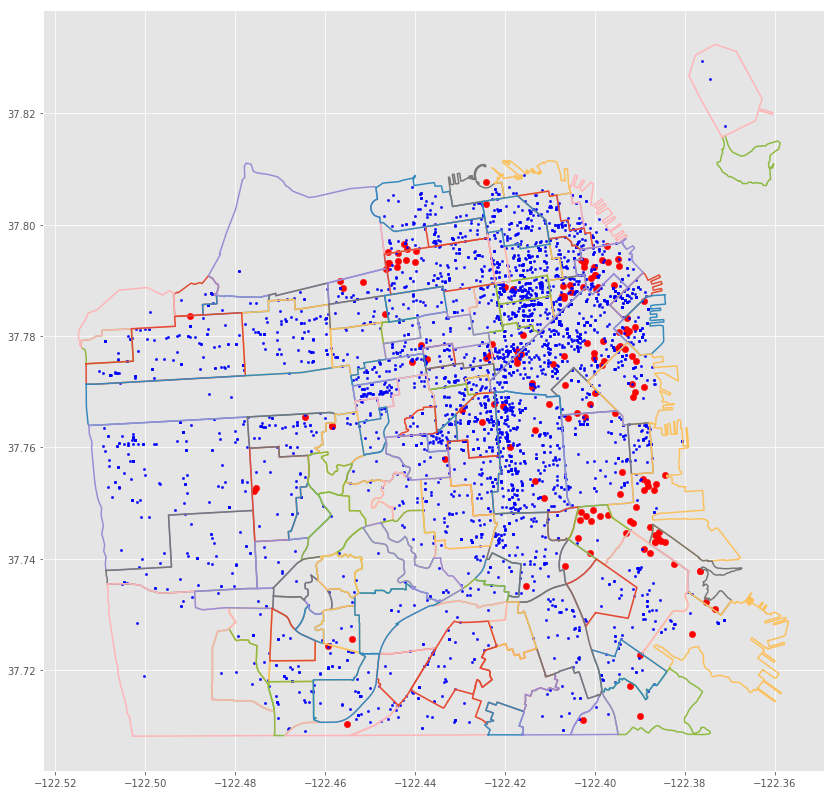

In [65]:
sf = shp.Reader("geo_export_94acb812-c280-4e39-b6ca-a186665f9748.shp" )
plt.figure(figsize=(14, 14))
for shape in sf.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x,y)
plt.scatter(mobile_vendor_place['Longitude'], mobile_vendor_place['Latitude'], color = 'red', s = 40)
plt.scatter(noise['Lon'],noise['Lat'],color = 'blue',s = 5)
plt.show()

__3.What are the best times and places to find food trucks?__

To figure out what are the best times and places to find food trucks, I select related information from tables of mobile_food_locations, mobile_food_permits and mobile_food_schedule. Compared to weekends, I find weekdays are the best time to find approved food trucks, and there are most food trucks on Friday. Then I map the distribution of food trucks on Friday. I use the packages 'folium' and 'geopandas' to make the map. I also use the shapefile of neighborhood in San Francisco to plot the boundary for this analysis. According to the map for different districts in the shapefile, we can see that Financial District, South Of Market District, Mission Bay District and Dogpatch District have most concentrated food trucks.

In [66]:
sql_query = """
select count(distinct locationid) num_of_vendors, DayOfWeek
from mobile_food_schedule s
inner join mobile_food_permits p on p.permit = s.permit
where FacilityType = 'Truck' and Status = 'APPROVED'
group by DayOfWeek
order by "num_of_vendors" desc
"""
time_vendors = pd.read_sql_query(sql_query, sf_data)
time_vendors

,num_of_vendors,DayOfWeek
0,119,Fr
1,118,Mo
2,118,We
3,116,Th
4,115,Tu
5,22,Sa
6,20,Su


In [67]:
sql_query = """
select distinct s.locationid, Latitude, Longitude, s.permit
from mobile_food_locations l
inner join mobile_food_schedule s on s.locationid = l.locationid
inner join mobile_food_permits p on p.permit = s.permit
where DayOfWeek = 'Fr' and Longitude < 0 and FacilityType = 'Truck' and Status = 'APPROVED'
"""
location = pd.read_sql_query(sql_query, sf_data)
location.head()

,locationid,Latitude,Longitude,permit
0,654163,37.793393,-122.402314,15MFF-0009
1,654165,37.793214,-122.397043,15MFF-0009
2,676176,37.788877,-122.420091,15MFF-0136
3,676797,37.796123,-122.397273,15MFF-0023
4,760539,37.777755,-122.394808,16MFF-0019


In [71]:
import folium
import geopandas as gp
SF = (37.76, -122.45)
MAX_RECORDS = 1000
map1 = folium.Map(location = SF, zoom_start = 13)
feature_group = folium.FeatureGroup("Locations")
for each in location[0:MAX_RECORDS].iterrows():
    feature_group.add_child(folium.Marker(location = [each[1]['Latitude'], each[1]['Longitude']]))
map1.add_child(feature_group)

districts = gp.GeoDataFrame.from_file("geo_export_94acb812-c280-4e39-b6ca-a186665f9748.shp")
folium.GeoJson(districts).add_to(map1)
map1 #couldn't see very clearly

In [73]:
from folium.plugins import MarkerCluster
SF = (37.76, -122.45)
map2= folium.Map(location = SF, zoom_start = 13)

coordinates = [tuple([each[1]['Latitude'], each[1]['Longitude']]) for each in location[0:MAX_RECORDS].iterrows()] 
map2.add_child(MarkerCluster(locations = coordinates, popups = coordinates))

districts = gp.GeoDataFrame.from_file('geo_export_94acb812-c280-4e39-b6ca-a186665f9748.shp')
folium.GeoJson(districts).add_to(map2)
map2

__4. Is there a relationship between housing prices and any of the other tables?__ Whether the high housing price in a region is related to the large number of schools in this region?

To explore the relationship between the housing price and the distribution of schools,in other words, whether housing price in a region is higher than others because of more schools in this region. I select information of schools and zillow in database and calulate the average of 'MedianSoldPricePerSqft' in table zillow grouped by region. I also convert zip code into latitude and longitude with package 'zipcode'. I make a map of housing price and distribution of schools with package 'folium', in which blue mark represents the center of each region and it has a popup of mean housing price when clicking on it and circle represents the number of schools near this circle. From the plot, we can see many schools concentrate in the northeast region and in regions with 43, 35, 26 schools, the housing prices are above 600 per square feet, much higher than other regions. However, in South Beach District, although it does not have so many schools, it still has a housing price as high as 798 per square feet, and it may be an important financial district.

In [74]:
schools = pd.read_sql_query('select * from schools', sf_data)
schools.head()

,Name,Entity,LowerGrade,UpperGrade,GradeRange,Category,LowerAge,UpperAge,GeneralType,Address,Lat,Lon
0,Alamo Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"250 23RD AVE, San Francisco, CA 94121",37.783005,-122.482300
1,Alvarado Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"625 DOUGLASS ST, San Francisco, CA 94114",37.753681,-122.438194
2,Aptos Middle School,SFUSD,6,8,6-8,USD Grades 6-8,11,13,PS,"105 APTOS AVE, San Francisco, CA 94127",37.729672,-122.465782
3,Argonne Early Education School,SFUSD,-2,0,PK-TK,USD PreK/TK,3,5,PS,"750 16TH AVE, San Francisco, CA 94118",37.773968,-122.474060
4,Argonne Elementary School,SFUSD,0,5,K-5,USD Grades K-5,5,10,PS,"680 18TH AVE, San Francisco, CA 94121",37.775307,-122.476311


In [75]:
zillow = pd.read_sql_query('select * from zillow', sf_data)
zillow.head()

,RegionName,Date,ZriPerSqft_AllHomes,MedianSoldPricePerSqft_AllHomes,PriceToRentRatio_AllHomes,Turnover_AllHomes
0,94109,2010-11-01 00:00:00,3.156,675.1913,19.14,6.0771
1,94110,2010-11-01 00:00:00,2.566,599.6785,18.10,5.4490
2,94122,2010-11-01 00:00:00,2.168,495.4432,17.99,2.4198
3,94080,2010-11-01 00:00:00,1.666,369.5538,18.31,3.8757
4,94112,2010-11-01 00:00:00,2.322,422.4538,14.44,3.1288


In [76]:
sql_query = """
select avg(MedianSoldPricePerSqft_AllHomes) mean_price, RegionName
from zillow
where MedianSoldPricePerSqft_AllHomes != "NaN"
group by RegionName
order by mean_price desc
"""
mean_house_price = pd.read_sql_query(sql_query, sf_data)
mean_house_price.head()

,mean_price,RegionName
0,1336.128581,94104
1,798.257824,94105
2,696.166788,94123
3,657.211820,94158
4,650.127729,94114


In [77]:
latitude = []
longitude = []
for i in range(0,len(mean_house_price)):
    Lon = zipcode.isequal(str(mean_house_price['RegionName'][i])).lon
    Lat = zipcode.isequal(str(mean_house_price['RegionName'][i])).lat
    latitude.append(Lat)
    longitude.append(Lon)
mean_house_price['Lat'] = latitude
mean_house_price['Lon'] = longitude
mean_house_price.head()

,mean_price,RegionName,Lat,Lon
0,1336.128581,94104,37.79,-122.40
1,798.257824,94105,37.78,-122.39
2,696.166788,94123,37.80,-122.43
3,657.211820,94158,37.76,-122.39
4,650.127729,94114,37.75,-122.43


In [79]:
from folium import plugins
map3 = folium.Map(location = SF, zoom_start = 13)
feature_group = folium.FeatureGroup("Locations")

coordinates = [tuple([each[1]['Lat'], each[1]['Lon']]) for each in schools[0:MAX_RECORDS].iterrows()] 
map3.add_child(MarkerCluster(locations = coordinates, popups = coordinates))

for each in mean_house_price[0:MAX_RECORDS].iterrows():
    feature_group.add_child(folium.Marker(location = [each[1]['Lat'], each[1]['Lon']], popup = str(each[1]['mean_price'])))
map3.add_child(feature_group)

districts = gp.GeoDataFrame.from_file('geo_export_94acb812-c280-4e39-b6ca-a186665f9748.shp')
folium.GeoJson(districts).add_to(map2)
map3

__5.Which type of crime is most common in San Francisco?__

To explore this question, I select information of crimes in database and count the type of crimes, and find theft from the car(GRAND THEFT FROM LOCKED AUTO) is the most common type.I also make a plot of the neighborhood areas and find the type of the most common crimes have changed. For example, in the Tenderloin district, shoplifting is the most common crime. Meanwhile there are some amusing results, such as marijuana possession appearing.

In [80]:
common_crimes=pd.read_sql("SELECT name, Descript, max(count) AS count "
                          "FROM (SELECT name, Descript, count(name) AS count FROM crime2 GROUP BY name, Descript) "
                          "GROUP BY name",sf_data)
common_crimes.head()

,name,Descript,count
0,Alamo Square,GRAND THEFT FROM LOCKED AUTO,749
1,Anza Vista,GRAND THEFT FROM LOCKED AUTO,618
2,Apparel City,"DRIVERS LICENSE, SUSPENDED OR REVOKED",480
3,Aquatic Park / Ft. Mason,GRAND THEFT FROM LOCKED AUTO,1119
4,Ashbury Heights,GRAND THEFT FROM LOCKED AUTO,145


In [81]:
pd.DataFrame(common_crimes.Descript.value_counts())

,Descript
GRAND THEFT FROM LOCKED AUTO,88
"DRIVERS LICENSE, SUSPENDED OR REVOKED",9
STOLEN AUTOMOBILE,7
PETTY THEFT SHOPLIFTING,2
LOST PROPERTY,1
"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",1
"CIVIL SIDEWALKS, CITATION",1
"AIDED CASE, DOG BITE",1
JUVENILE INVOLVED,1
UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE,1


In [82]:
common_df=sf_neighborhoods.merge(common_crimes,on="name").dissolve(by="Descript").reset_index()
common_df.geometry=gpd.GeoSeries([shapely.ops.cascaded_union(district.buffer(.0001)) for district in common_df.geometry])
common_df['coords'] = common_df['geometry'].apply(lambda x: x.representative_point().coords[:])
common_df['coords'] = [coords[0] for coords in common_df['coords']]

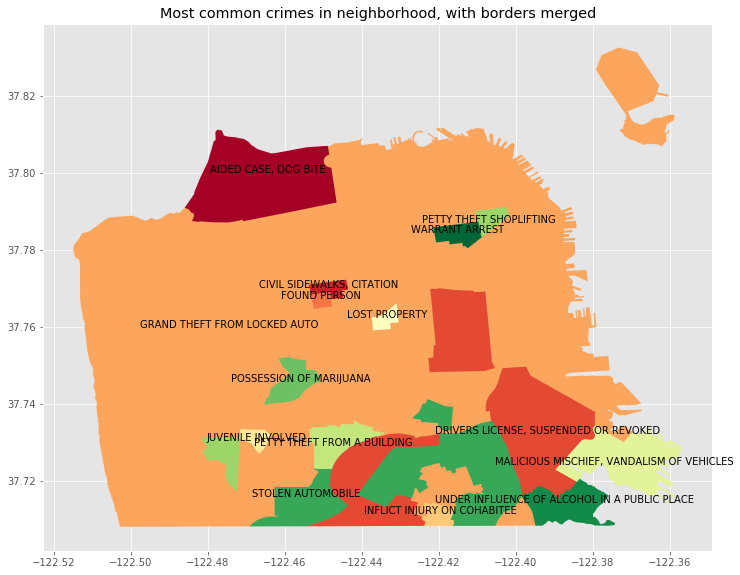

In [83]:
common_df.plot(figsize=(12, 12),column="Descript",cmap="RdYlGn",linewidth=1)
for idx, row in common_df.iterrows():
    plt.annotate(s=row['Descript'], xy=row['coords'],
                 horizontalalignment='center')
plt.title("Most common crimes in neighborhood, with borders merged")
plt.show()

__Finally__

In [84]:
sf_data.close()